In [1]:
import os
import pandas as pd
import numpy as np
import warnings
import pickle
import math
from sklearn.metrics import r2_score, make_scorer, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import brier_score_loss, matthews_corrcoef
from collections import OrderedDict, Counter
from copy import deepcopy
from scipy.stats import pearsonr, sem
from measure_function import calclass
from sklearn.metrics import roc_curve, auc

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

from measure_function import *

kB = 1.9872036*(10**(-3))  # kcal mol^-1 K^-1

In [2]:
# ======================================
# Function we will use for scatter plots
# ======================================
def plot_corr(ax, x, y, xerr=None, yerr=None, xlim=[-5,+5], ylim=[-5,+5], title='', legendloc=None,
              fit=True, diagonal=True, labelsize=16, msize=90, yax=1.36, xax=1.36,
              colorbar=False, vmin=0.0, vmax=2.8, cbarlabel='cbar', cbar_shrink=1.0, cbar_pad=0.15):
  
    # the absolute error for each data point
    diff = np.abs(x-y)
    cmap = plt.cm.coolwarm
    
    SC = ax.scatter(x=x, 
                    y=y, 
                    c=diff, 
                    cmap=cmap, 
                    s=msize,
                    edgecolors='k',
                    linewidths=1.2, 
                    zorder=10, 
                    vmin=0.0, 
                    vmax=2.8, 
                    label='_nolegend_')    
    
    if yerr is None and xerr is not None:
        ax.errorbar(x=x, y=y, xerr=xerr, fmt=None, marker=None, 
                color='k', linewidth=1.2, zorder=0, label='_nolegend_')
    elif yerr is not None and xerr is not None:
        ax.errorbar(x=x, y=y, xerr=xerr, yerr=yerr, fmt='none', marker=None, 
                color='k', linewidth=1.2, zorder=0, label='_nolegend_')
    
    # Make ColorBar
    if colorbar is True:
        cbarticks = [0.0, 0.7, 1.4, 2.1, 2.8]
        cbar = fig.colorbar(SC, ax=ax, shrink=cbar_shrink, pad=cbar_pad, ticks=cbarticks)
        cbar.set_label(cbarlabel, fontsize=labelsize)
        cax = plt.gcf().axes[-1]
        cax.tick_params(labelsize=labelsize)
    
    # Ticks and labels
    ax.set_xlabel(r'Experimental $\Delta\Delta G$, kcal/mol', fontsize=labelsize)
    ax.set_ylabel(r'Calculated $\Delta\Delta G$, kcal/mol', fontsize=labelsize)
  
    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
    
    xmin = min(xlim)
    xmax = max(xlim)
    ymin = min(ylim)
    ymax = max(ylim)
    
    if title != '':
        ax.set_title(title, fontsize=labelsize*1.2)
    
    # add diagonal
    if diagonal is True:
        ax.plot([xmin,xmax], [xmin,xmax], '--', color='gray')

    # add zero axes
    ax.axvline(x=xax, color='k', linestyle='-', linewidth=1.2)
    ax.axhline(y=yax, color='k', linestyle='-', linewidth=1.2)
    
    # shaded area indicating 1,2 kcal/mol errors
    a = [xmin,xmax]
    b = [j+1.4 for j in a]
    c = [j-1.4 for j in a]
    ax.fill_between(a, b, c, alpha=0.1, interpolate=True, color='k')
    
    # Linear fit
    if fit is True:
        fit = np.polyfit(x, y, 1)
        fit_fn = np.poly1d(fit)
        x_fit = np.linspace(xmin, xmax, len(x)) 
        y_fit = fit_fn(x_fit)
        ax.plot(x_fit, y_fit, '-', color='k', zorder=1, 
                label='$\Delta\Delta G_{calc} = %.2f \cdot \Delta\Delta G_{exp} %+.2f$' %(fit[0],fit[1]))

    # grid
    ax.grid(b=True, which='major', color='0.5',linestyle=':')

    ax.set_xlim([xmax,xmin])
    ax.set_ylim([ymax,ymin])
    
    # Make box square
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(aspect=(x1-x0)/(y1-y0))
    
    # make legend
    if legendloc is not None:
        legend = ax.legend(loc=legendloc, prop={'size':labelsize*0.8})

# ====================
# Performance measures
# ====================
def get_rmse(x,y):
    return np.sqrt((np.mean((x-y)**2)))


def get_pearson(x,y):
    return pearsonr(x,y)[0]

def get_auc_roc(y,y_pred):
    true_bool = np.array([i > 0.0 for i in y])
    scores = np.array(y_pred)
    auc = roc_auc_score(true_bool, scores)
    return auc

def get_auc_prc(exp, calc):
    true_bool = np.array([x > 1.36 for x in exp]) # identify resistant mutations (ddG > 1.36 kcal/mol)
    scores = np.array(calc) # the scores are the calc ddg (higher ddg = higher probability of resistance)
    precision, recall, thresholds = precision_recall_curve(true_bool, scores)
    auc_score = auc(recall, precision)
    
    return auc_score
    
# define additional sklearn scores
my_pearson = make_scorer(get_pearson, greater_is_better=True)
my_rmse = make_scorer(get_rmse, greater_is_better=False)
my_roc = make_scorer(get_auc_roc, greater_is_better=True)
my_prc = make_scorer(get_auc_prc, greater_is_better=True)

# Scatter plots of experimental versus calculated ΔΔG values

In [3]:
data = pd.read_csv("./Data/Data_S1_all.csv", sep = ',')
data1 = data
data.head()

,TKI,LIGAND_ID,Index,WT_PDB,MUTATION,EXP.DDG,A99.DDG,A99.DDG_ERR,A99L.DDG,A99L.DDG_ERR,...,ML2SPLD_max.DDG,ML2_avg.REF15,ML2_max.REF15,ML2SPL_avg.REF15,ML2SPL_max.REF15,ML2SPLD_avg.REF15,ML2SPLD_max.REF15,ML3_ExtraTree,ML3_SPL,ML3_SPLD
0,axitinib,AXI,1,4WA9,M244V,-0.11,-0.23,0.33,-0.60,0.21,...,0.13,0.22,0.32,0.10,0.15,0.09,0.17,0.27,0.31,0.25
1,gefitinib,IRE,2,4WA9,L248R,0.31,0.16,0.87,0.55,0.56,...,0.47,1.39,1.63,0.26,0.44,0.22,0.44,2.64,1.24,1.24
2,gefitinib,IRE,3,4WA9,L248V,0.32,0.16,0.48,-0.41,0.33,...,0.29,0.42,0.54,0.21,0.31,0.19,0.32,0.29,0.53,0.43
3,dasatinib,1N1,4,4WA9,G250E,0.27,0.31,0.17,-0.09,0.13,...,0.38,1.09,1.31,0.25,0.41,0.28,0.38,0.40,0.41,0.61
4,dasatinib,1N1,5,4WA9,Q252H,0.20,-0.50,0.85,-0.55,0.54,...,0.28,0.47,0.61,0.16,0.23,0.17,0.27,0.14,0.60,0.20


In [4]:
data = data.rename(columns={'A99.DDG':'Amber99sb-ILDN [A99]'})
data = data.rename(columns={'A99L.DDG':'A99(long protocol) [A99l]'})
data = data.rename(columns={'R15.DDG':'Rosetta / REF15'})
data = data.rename(columns={'ML1.DDG':'ExtraTrees* (extrapolating)'})
data = data.rename(columns={'ML1SPL_avg.DDG':'SPLExtraTrees_org (extrapolating)'})
data = data.rename(columns={'ML1SPLD_avg.DDG':'SPLDExtraTrees_org (extrapolating)'})
data = data.rename(columns={'ML1_avg.REF15':'ExtraTrees (extrapolating)'})
data = data.rename(columns={'ML1SPL_avg.REF15':'SPLExtraTrees (extrapolating)'})
data = data.rename(columns={'ML1SPLD_avg.REF15':'SPLDExtraTrees (extrapolating)'})
data = data.rename(columns={'ML2.DDG':'ExtraTrees* (interpolating)'})
data = data.rename(columns={'ML2SPL_avg.DDG':'SPLExtraTrees_org (interpolating)'})
data = data.rename(columns={'ML2SPLD_avg.DDG':'SPLDExtraTrees_org (interpolating)'})
data = data.rename(columns={'ML2_avg.REF15':'ExtraTrees (interpolating)'})
data = data.rename(columns={'ML2SPL_avg.REF15':'SPLExtraTrees (interpolating)'})
data = data.rename(columns={'ML2SPLD_avg.REF15':'SPLDExtraTrees (interpolating)'})
data = data.rename(columns={'ML3_ExtraTree':'ExtraTrees (extrapolating_kinase)'})
data = data.rename(columns={'ML3_SPL':'SPLExtraTrees (extrapolating_kinase)'})
data = data.rename(columns={'ML3_SPLD':'SPLDExtraTrees (extrapolating_kinase)'})

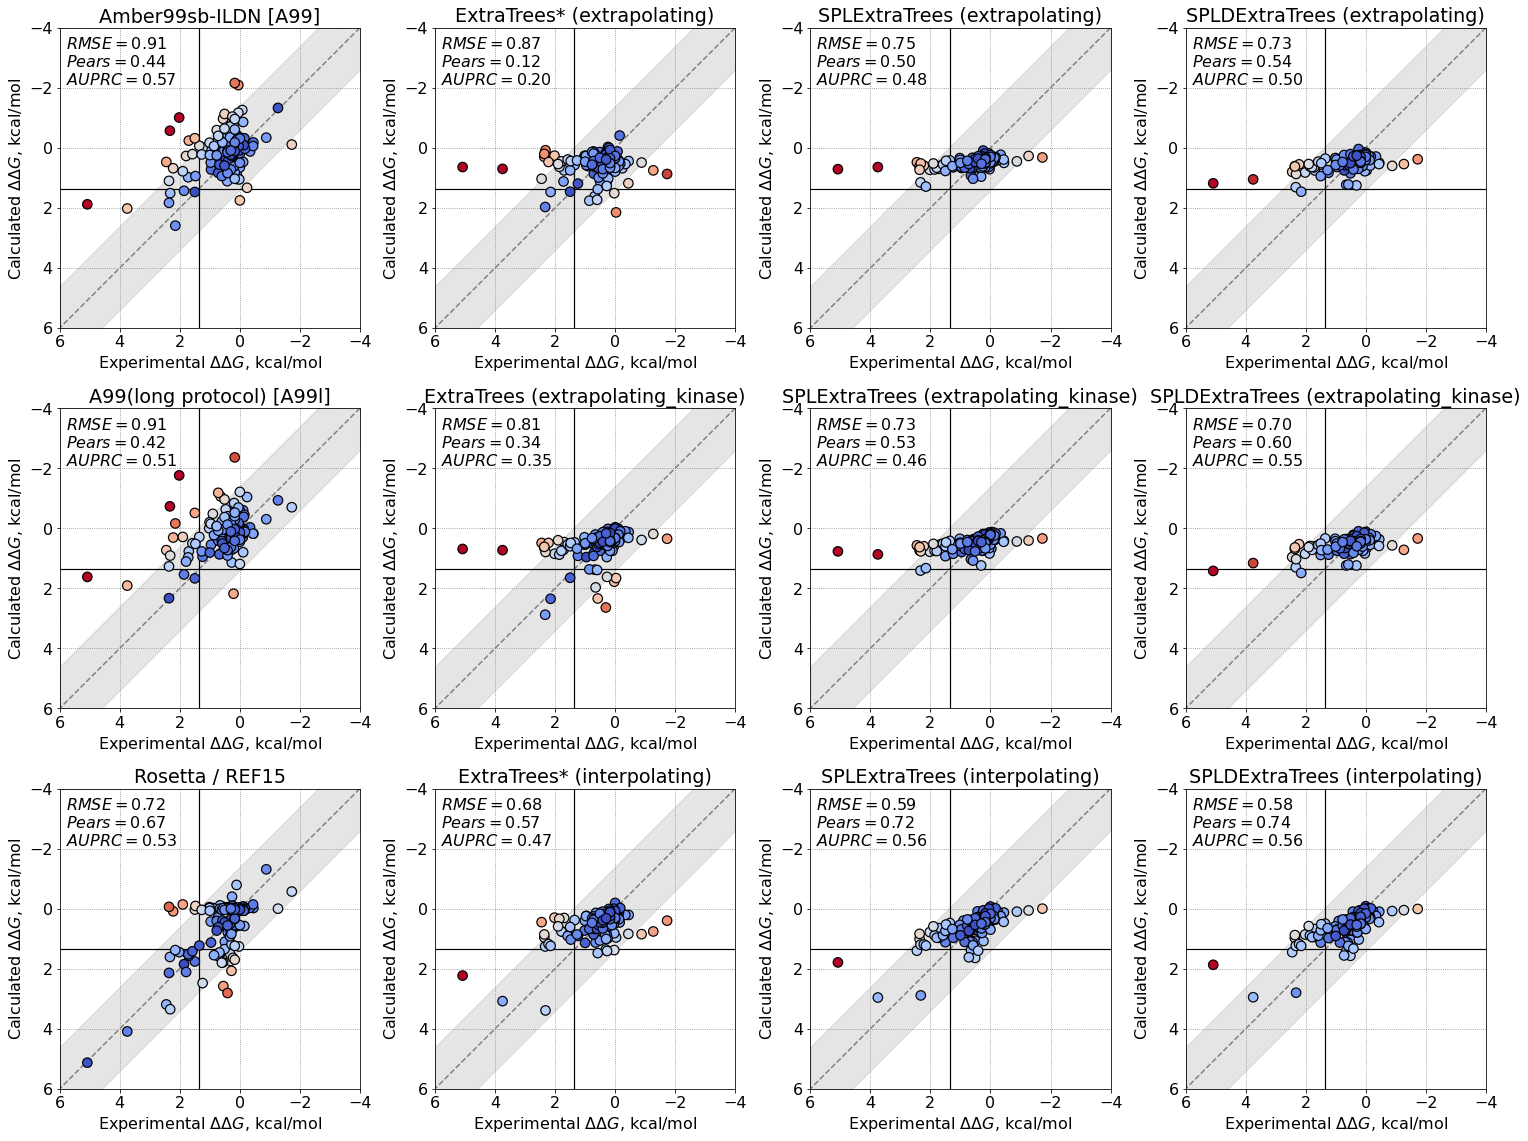

In [5]:
method_list = ['Amber99sb-ILDN [A99]', 'ExtraTrees* (extrapolating)', 'SPLExtraTrees (extrapolating)', 'SPLDExtraTrees (extrapolating)',
               'A99(long protocol) [A99l]','ExtraTrees (extrapolating_kinase)', 'SPLExtraTrees (extrapolating_kinase)', 'SPLDExtraTrees (extrapolating_kinase)',
               'Rosetta / REF15', 'ExtraTrees* (interpolating)', 'SPLExtraTrees (interpolating)','SPLDExtraTrees (interpolating)']


#method_list = ['ML1.DDG', 'ML1SPL_avg.DDG', 'ML1SPLD_avg.DDG','ML1_avg.REF15','ML1SPL_avg.REF15','ML1SPLD_avg.REF15']
nrows = 3
ncols=int(len(method_list)/nrows)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(21, 16))

tmp = 0
tmp1 = 0
for i in method_list:
    T = 300
    ddg_exp = data['EXP.DDG']
    ddg_calc = data[i]

    # set ax according to the subplots
    ax = axes[tmp][tmp1]
    
    xlim = [-4, 6]
    ylim = [-4, 6]
    
    RMSE = get_rmse(ddg_exp, ddg_calc)
    Pears = pearsonr(ddg_exp, ddg_calc)[0]
    PRC = get_auc_prc(ddg_exp, ddg_calc)
    
    plot_corr(ax, ddg_exp, ddg_calc, title=i, fit=False, xlim=xlim, ylim=ylim)
    
    annx = 5.8
    anny = -3.3
    asep = -0.6
    fs=16
    _ = ax.annotate('$RMSE  = %.2f$' % (RMSE), xy=(annx, anny), zorder=10, fontsize=fs)
    _ = ax.annotate('$Pears = %.2f$' % (Pears), xy=(annx, anny-asep), zorder=10, fontsize=fs)
    _ = ax.annotate('$AUPRC   = %.2f$' % (PRC), xy=(annx, anny-2*asep), zorder=10, fontsize=fs)
    
    if tmp1 == (ncols -1):
        tmp += 1
        tmp1 = 0
    else:
        tmp1 += 1

# --------
# Fix look
# --------
ax.set_xticks([-4, -2, 0, 2, 4, 6])
fig.tight_layout()

In [6]:
threshold_ddG = 1.36
threshold_top = 0.2
Y_true = data["EXP.DDG"]
Y_pred_list = ['Amber99sb-ILDN [A99]', 'A99(long protocol) [A99l]', 'Rosetta / REF15',
               'ExtraTrees* (extrapolating)', 'SPLExtraTrees (extrapolating)', 'SPLDExtraTrees (extrapolating)',
               'ExtraTrees (extrapolating_kinase)', 'SPLExtraTrees (extrapolating_kinase)', 'SPLDExtraTrees (extrapolating_kinase)',
               'ExtraTrees* (interpolating)', 'SPLExtraTrees (interpolating)','SPLDExtraTrees (interpolating)']
# Calculate the binary classification performance
for i in Y_pred_list:
    Y_pred = data[i]
    perf_ddG = binary_perf_ddG(Y_true, Y_pred, threshold_ddG)
    perf_top = binary_perf_top(Y_true, Y_pred, threshold_top)
    
    print("\n", i)
    #print("-------------------- Avg_ddG -------------------")
    #for k, v in perf_ddG.items():
    #    print(k, ": %.2f" % v)
    print("-------------------- Avg_top -------------------")
    for k, v in perf_top.items():
        print(k, ": %.2f" % v)


 Amber99sb-ILDN [A99]
-------------------- Avg_top -------------------
Recall : 0.63
Precision : 0.43
Balanced Accuracy : 0.75
F1 Score : 0.51
Matthews Correlation Coefficient : 0.43

 A99(long protocol) [A99l]
-------------------- Avg_top -------------------
Recall : 0.58
Precision : 0.39
Balanced Accuracy : 0.72
F1 Score : 0.47
Matthews Correlation Coefficient : 0.38

 Rosetta / REF15
-------------------- Avg_top -------------------
Recall : 0.68
Precision : 0.46
Balanced Accuracy : 0.78
F1 Score : 0.55
Matthews Correlation Coefficient : 0.48

 ExtraTrees* (extrapolating)
-------------------- Avg_top -------------------
Recall : 0.37
Precision : 0.25
Balanced Accuracy : 0.60
F1 Score : 0.30
Matthews Correlation Coefficient : 0.17

 SPLExtraTrees (extrapolating)
-------------------- Avg_top -------------------
Recall : 0.47
Precision : 0.32
Balanced Accuracy : 0.66
F1 Score : 0.38
Matthews Correlation Coefficient : 0.28

 SPLDExtraTrees (extrapolating)
-------------------- Avg_top --

/data/yangziyi/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/yangziyi/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


## PRC curve

In [7]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import os
import pandas as pd
import numpy as np
import warnings
import pickle
import math
from sklearn.metrics import r2_score, make_scorer, roc_auc_score, precision_recall_curve, auc, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score
from collections import OrderedDict, Counter
from copy import deepcopy
from scipy.stats import pearsonr, sem
from measure_function import calclass

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [8]:
data = pd.read_csv("./Data/Data_S1_all.csv", sep = ',')
data1 = data
data.head()

,TKI,LIGAND_ID,Index,WT_PDB,MUTATION,EXP.DDG,A99.DDG,A99.DDG_ERR,A99L.DDG,A99L.DDG_ERR,...,ML2SPLD_max.DDG,ML2_avg.REF15,ML2_max.REF15,ML2SPL_avg.REF15,ML2SPL_max.REF15,ML2SPLD_avg.REF15,ML2SPLD_max.REF15,ML3_ExtraTree,ML3_SPL,ML3_SPLD
0,axitinib,AXI,1,4WA9,M244V,-0.11,-0.23,0.33,-0.60,0.21,...,0.13,0.22,0.32,0.10,0.15,0.09,0.17,0.27,0.31,0.25
1,gefitinib,IRE,2,4WA9,L248R,0.31,0.16,0.87,0.55,0.56,...,0.47,1.39,1.63,0.26,0.44,0.22,0.44,2.64,1.24,1.24
2,gefitinib,IRE,3,4WA9,L248V,0.32,0.16,0.48,-0.41,0.33,...,0.29,0.42,0.54,0.21,0.31,0.19,0.32,0.29,0.53,0.43
3,dasatinib,1N1,4,4WA9,G250E,0.27,0.31,0.17,-0.09,0.13,...,0.38,1.09,1.31,0.25,0.41,0.28,0.38,0.40,0.41,0.61
4,dasatinib,1N1,5,4WA9,Q252H,0.20,-0.50,0.85,-0.55,0.54,...,0.28,0.47,0.61,0.16,0.23,0.17,0.27,0.14,0.60,0.20


In [9]:
data = data.rename(columns={'A99.DDG':'Amber99sb-ILDNA [A99]'})
data = data.rename(columns={'A99L.DDG':'A99l'})
data = data.rename(columns={'R15.DDG':'Rosetta / REF15'})
data = data.rename(columns={'ML1.DDG':'ExtraTrees* (extrapolating)'})
data = data.rename(columns={'ML1SPL_avg.DDG':'SPLExtraTrees_org (extrapolating)'})
data = data.rename(columns={'ML1SPLD_avg.DDG':'SPLDExtraTrees_org (extrapolating)'})
data = data.rename(columns={'ML1_avg.REF15':'ExtraTrees (extrapolating)'})
data = data.rename(columns={'ML1SPL_avg.REF15':'SPLExtraTrees (extrapolating)'})
data = data.rename(columns={'ML1SPLD_avg.REF15':'SPLDExtraTrees (extrapolating)'})


data1 = data1.rename(columns={'A99.DDG':'Amber99sb-ILDNA [A99]'})
data1 = data1.rename(columns={'A99L.DDG':'A99l'})
data1 = data1.rename(columns={'R15.DDG':'Rosetta / REF15'})
data1 = data1.rename(columns={'ML2.DDG':'ExtraTrees* (interpolating)'})
data1 = data1.rename(columns={'ML2SPL_avg.DDG':'SPLExtraTrees_org (interpolating)'})
data1 = data1.rename(columns={'ML2SPLD_avg.DDG':'SPLDExtraTrees_org (interpolating)'})
data1 = data1.rename(columns={'ML2_avg.REF15':'ExtraTrees (interpolating)'})
data1 = data1.rename(columns={'ML2SPL_avg.REF15':'SPLExtraTrees (interpolating)'})
data1 = data1.rename(columns={'ML2SPLD_avg.REF15':'SPLDExtraTrees (interpolating)'})

data = data.rename(columns={'ML3_ExtraTree':'ExtraTrees (Scenario 3)'})
data = data.rename(columns={'ML3_SPL':'SPLExtraTrees (Scenario 3)'})
data = data.rename(columns={'ML3_SPLD':'SPLDExtraTrees (Scenario 3)'})

<ipython-input-10-9f495ac5e33b>:41: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(recall, precision, linewidth=5, Zorder=1)
<ipython-input-10-9f495ac5e33b>:41: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(recall, precision, linewidth=5, Zorder=1)
<ipython-input-10-9f495ac5e33b>:41: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(recall, precision, linewidth=5, Zorder=1)
<ipython-input-10-9f495ac5e33b>:41: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(recall, precision, linewidth=5, Zorder=1)
<ipython-input-10-9f495ac5e33b>:41: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in

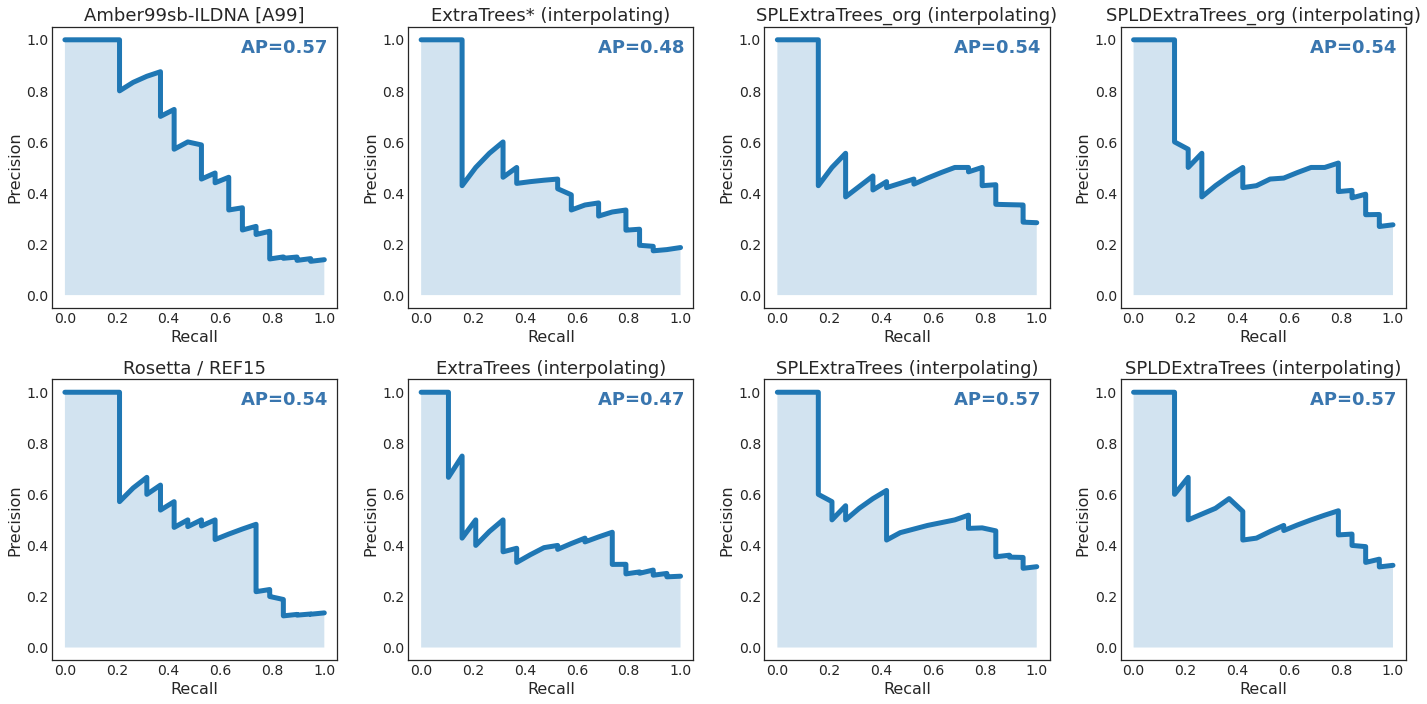

In [10]:
method_list = ['Amber99sb-ILDNA [A99]', 'ExtraTrees* (interpolating)', 'SPLExtraTrees_org (interpolating)', 
               'SPLDExtraTrees_org (interpolating)',
               'Rosetta / REF15',
               'ExtraTrees (interpolating)','SPLExtraTrees (interpolating)','SPLDExtraTrees (interpolating)']

threshold = 1.36

plt.style.use('seaborn-white')
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['font.serif'] = ['Calibri']
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['font.size'] = 14

nrows = 2
ncols=int(len(method_list)/nrows)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,10))

tmp = 0
tmp1 = 0
for i in method_list:
    
    ax = axes[tmp][tmp1]
    
    true_values = data1['EXP.DDG']
    true_label = calclass(data1['EXP.DDG'], threshold)
    predict_values = data1[i]
    predict_label = calclass(data1[i], threshold)
    label = i
    
    precision, recall, thresholds = precision_recall_curve(true_label, predict_values)
    
    #AUPRC = pearsonr(true_values, predict_values)[0]
    Recall = recall_score(true_label, predict_label)
    Precision = precision_score(true_label, predict_label)
    AP = average_precision_score(true_label, predict_values)
    
    ax.text(0.68, 0.95,'AP={:.2f} '.format(AP), fontdict = {'size': 18, 'color': '#3976AF', 'weight': 'bold'})
    
    
    ax.plot(recall, precision, linewidth=5, Zorder=1)
    ax.fill_between(recall, precision, interpolate=True, alpha=0.2)
    #plt.scatter(Recall_score, Precision_score, marker='o', c='lightseagreen', s=500, edgecolors='w', linewidths=4, Zorder=2)
    #plt.scatter(Recall_score_top,Precision_score_top, marker='o', c='tomato', s=500, edgecolors='w', linewidths=4, Zorder=2)
    
    title = i
    ax.set_title(title, fontsize=18)
    ax.set_xlabel("Recall", fontsize=16)
    ax.set_ylabel("Precision", fontsize=16)
    ax.set_xticks((0,0.2,0.4,0.6,0.8,1.0))
    ax.set_yticks((0,0.2,0.4,0.6,0.8,1.0))
    
    #tmp += 1
    
    if tmp1 == (ncols -1):
        tmp += 1
        tmp1 = 0
    else:
        tmp1 += 1

fig.tight_layout()

## ROC curve

In [11]:
data = pd.read_csv("./Data/Data_S1_all.csv", sep = ',')

In [12]:
data1 = data
data = data.rename(columns={'A99.DDG':'Amber99sb-ILDNA [A99]'})
data = data.rename(columns={'A99L.DDG':'A99l'})
data = data.rename(columns={'R15.DDG':'Rosetta / REF15'})
data = data.rename(columns={'ML1.DDG':'ExtraTrees* (extrapolating)'})
data = data.rename(columns={'ML1SPL_avg.DDG':'SPLExtraTrees_org (extrapolating)'})
data = data.rename(columns={'ML1SPLD_avg.DDG':'SPLDExtraTrees_org (extrapolating)'})
data = data.rename(columns={'ML1_avg.REF15':'ExtraTrees (extrapolating)'})
data = data.rename(columns={'ML1SPL_avg.REF15':'SPLExtraTrees (extrapolating)'})
data = data.rename(columns={'ML1SPLD_avg.REF15':'SPLDExtraTrees (extrapolating)'})


data1 = data1.rename(columns={'A99.DDG':'Amber99sb-ILDNA [A99]'})
data1 = data1.rename(columns={'A99L.DDG':'A99l'})
data1 = data1.rename(columns={'R15.DDG':'Rosetta / REF15'})
data1 = data1.rename(columns={'ML2.DDG':'ExtraTrees* (interpolating)'})
data1 = data1.rename(columns={'ML2SPL_avg.DDG':'SPLExtraTrees_org (interpolating)'})
data1 = data1.rename(columns={'ML2SPLD_avg.DDG':'SPLDExtraTrees_org (interpolating)'})
data1 = data1.rename(columns={'ML2_avg.REF15':'ExtraTrees (interpolating)'})
data1 = data1.rename(columns={'ML2SPL_avg.REF15':'SPLExtraTrees (interpolating)'})
data1 = data1.rename(columns={'ML2SPLD_avg.REF15':'SPLDExtraTrees (interpolating)'})

<ipython-input-13-41ac9e85f101>:47: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(fpr, tpr, lw=4, color='#4682B4', Zorder=1)
<ipython-input-13-41ac9e85f101>:47: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(fpr, tpr, lw=4, color='#4682B4', Zorder=1)
<ipython-input-13-41ac9e85f101>:47: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(fpr, tpr, lw=4, color='#4682B4', Zorder=1)
<ipython-input-13-41ac9e85f101>:47: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(fpr, tpr, lw=4, color='#4682B4', Zorder=1)
<ipython-input-13-41ac9e85f101>:47: MatplotlibDeprecationWarning: Case-insensitive properties were deprecate

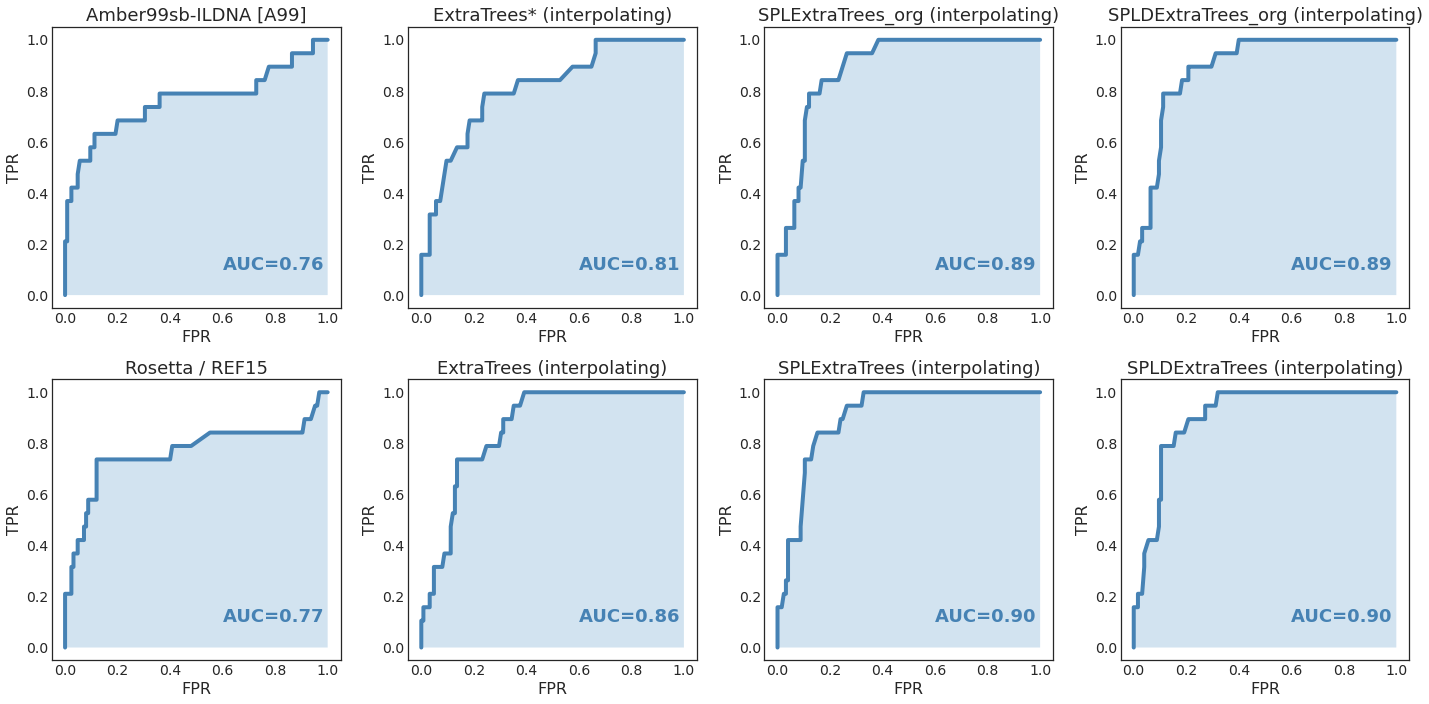

In [13]:
"""
method_list = ['Amber99sb-ILDNA [A99]', 'ExtraTrees* (extrapolating)', 'SPLExtraTrees_org (extrapolating)', 
               'SPLDExtraTrees_org (extrapolating)',
               'Rosetta / REF15',
               'ExtraTrees (extrapolating)','SPLExtraTrees (extrapolating)','SPLDExtraTrees (extrapolating)']
"""
method_list = ['Amber99sb-ILDNA [A99]', 'ExtraTrees* (interpolating)', 'SPLExtraTrees_org (interpolating)', 
               'SPLDExtraTrees_org (interpolating)',
               'Rosetta / REF15',
               'ExtraTrees (interpolating)','SPLExtraTrees (interpolating)','SPLDExtraTrees (interpolating)']

'''
method_list = ['ExtraTree', 'SPLExtraTree', 'SPLDExtraTree',
               'ExtraTree_REF15','SPLExtraTree_REF15','SPLDExtraTree_REF15']
'''

threshold = 1.36
add_auc = True

nrows = 2
ncols=int(len(method_list)/nrows)

plt.style.use('seaborn-white')
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['font.serif'] = ['Calibri']
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['font.size'] = 14

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,10))

tmp = 0
tmp1 = 0
for i in method_list:
    
    ax = axes[tmp][tmp1]
    
    true_values = data1['EXP.DDG']
    true_label = calclass(data1['EXP.DDG'], threshold)
    predict_values = data1[i]
    predict_label = calclass(data1[i], threshold)
    title = i
    
    precision, recall, thresholds = precision_recall_curve(true_label, predict_values)
    fpr, tpr, thresholds = roc_curve(true_label, predict_values)
    roc_auc = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, lw=4, color='#4682B4', Zorder=1)
    ax.fill_between(fpr, tpr, interpolate=True, alpha=0.2)
    ax.set_title(title, fontsize=18)
    ax.set_xlabel('FPR', fontsize=16)
    ax.set_ylabel('TPR', fontsize=16)
    ax.text(0.6, 0.1,'AUC={:.2f} '.format(roc_auc), fontdict = {'size': 18, 'color': '#4682B4', 'weight': 'bold'})
    plt.tick_params(labelsize=14)
       
    if tmp1 == (ncols -1):
        tmp += 1
        tmp1 = 0
    else:
        tmp1 += 1

fig.tight_layout()